In [1]:
import numpy as np
import pandas as pd
import wmfdata as wmf
from wmfdata.utils import pd_display_all

import plotly.express as px

## Wiki-level active editors

In [ ]:
ae_new = wmf.spark.run("""
SELECT
    wiki_id,
    COUNT(*) AS active_editor_count,
    COUNT_IF(TRUNC(user_global_registration_dt, 'MM') = month) AS new_active_editor_count,
    COUNT(*) - COUNT_IF(TRUNC(user_global_registration_dt, 'MM') = month)
        AS returning_active_editor_count
FROM wmf_contributors.editor_month
LEFT JOIN canonical_data.wikis
    ON wiki_id = database_code
WHERE
    month = DATE '2024-06'
    AND content_edit_count >= 5
    AND NOT user_is_bot
    AND NOT user_is_ip
GROUP BY wiki_id
ORDER BY wiki_id
""").set_index("wiki_id")

In [97]:
ae_new

active_editor_count  new_active_editor_count  \
wiki_id                                                       
abwiki                           3                        0   
acewiki                          3                        0   
adywiki                          1                        0   
afwiki                          40                        7   
alswiki                          5                        0   
...                            ...                      ...   
zhwikisource                    48                        2   
zhwikiversity                   29                        1   
zhwikivoyage                     7                        1   
zhwiktionary                    26                        1   
zuwiki                           5                        0   

               returning_active_editor_count  
wiki_id                                       
abwiki                                     3  
acewiki                                    3  
adywiki                                    1  
afwiki                                    33  
alswiki                                    5  
...                                      ...  
zhwikisource                              46  
zhwikiversity                             28  
zhwikivoyage                               6  
zhwiktionary                              25  
zuwiki                                     5  

[602 rows x 3 columns]

In [98]:
ae_old = wmf.spark.run("""
SELECT
    project AS wiki_id,
    active_editors AS active_editor_count,
    new_active_editors AS new_active_editor_count,
    returning_active_editors AS returning_active_editor_count
FROM wmf_product.active_editors
WHERE
    month = DATE '2024-06'
    AND project != 'All'
ORDER BY wiki_id
""").set_index("wiki_id")

In [99]:
ae_old

active_editor_count  new_active_editor_count  \
wiki_id                                                      
abwiki                          3                      0.0   
acewiki                         3                      0.0   
adywiki                         1                      0.0   
afwiki                         40                      7.0   
alswiki                         5                      0.0   
...                           ...                      ...   
zhwikiquote                     4                      0.0   
zhwikisource                   48                      3.0   
zhwikivoyage                    7                      1.0   
zhwiktionary                   26                      2.0   
zuwiki                          5                      1.0   

              returning_active_editor_count  
wiki_id                                      
abwiki                                  3.0  
acewiki                                 3.0  
adywiki                                 1.0  
afwiki                                 33.0  
alswiki                                 5.0  
...                                     ...  
zhwikiquote                             4.0  
zhwikisource                           45.0  
zhwikivoyage                            6.0  
zhwiktionary                           24.0  
zuwiki                                  4.0  

[585 rows x 3 columns]

Hmm! The new results have more projects, even though both ultimately derive from the same snapshot of `mediawiki_history`.

In [102]:
set(ae_old.index) - set(ae_new.index)

set()

In [103]:
set(ae_new.index) - set(ae_old.index)

{'arwikiversity',
 'cswikiversity',
 'dewikiversity',
 'enwikiversity',
 'eswikiversity',
 'foundationwiki',
 'frwikiversity',
 'hiwikiversity',
 'incubatorwiki',
 'itwikiversity',
 'jawikiversity',
 'kowikiversity',
 'ptwikiversity',
 'ruwikiversity',
 'slwikiversity',
 'sourceswiki',
 'zhwikiversity'}

Ah, okay. It seems like the existing [`update_project_active_editors.hql`](https://github.com/wikimedia/analytics-wmf-product-jobs/blob/master/movement_metrics/notebooks/supplementary/queries/update_project_active_editors.hql) accidentally leaves out a few database groups that should be included.


In [131]:
ae = ae_old.join(ae_new, lsuffix="_old", rsuffix="_new")

In [132]:
ae.info()

<class 'pandas.core.frame.DataFrame'>
Index: 585 entries, abwiki to zuwiki
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   active_editor_count_old            585 non-null    int64  
 1   new_active_editor_count_old        579 non-null    float64
 2   returning_active_editor_count_old  579 non-null    float64
 3   active_editor_count_new            585 non-null    int64  
 4   new_active_editor_count_new        585 non-null    int64  
 5   returning_active_editor_count_new  585 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 48.2+ KB


Hmm! Why are there some nulls in the new and returning columns of the old results?

In [134]:
rows_with_nulls = ae.isna().any(axis="columns")
ae[rows_with_nulls]

active_editor_count_old  new_active_editor_count_old  \
wiki_id                                                              
cawikiquote                         1                          NaN   
fawikinews                          1                          NaN   
fiwikibooks                         1                          NaN   
huwikiquote                         1                          NaN   
mniwiki                             1                          NaN   
svwikivoyage                        1                          NaN   

              returning_active_editor_count_old  active_editor_count_new  \
wiki_id                                                                    
cawikiquote                                 NaN                        1   
fawikinews                                  NaN                        1   
fiwikibooks                                 NaN                        1   
huwikiquote                                 NaN                        1   
mniwiki                                     NaN                        1   
svwikivoyage                                NaN                        1   

              new_active_editor_count_new  returning_active_editor_count_new  
wiki_id                                                                       
cawikiquote                             0                                  1  
fawikinews                              0                                  1  
fiwikibooks                             0                                  1  
huwikiquote                             0                                  1  
mniwiki                                 0                                  1  
svwikivoyage                            0                                  1

I believe these are cases where the the only user at these projects had a null local registration date, so the expression to calculate the status also returned null. 

In [135]:
ae = ae[~rows_with_nulls].applymap(int)

In [139]:
(
    ae
    .query("active_editor_count_old != active_editor_count_new")
    .assign(active_editor_diff=lambda df: df["active_editor_count_new"] - df["active_editor_count_old"])
    ["active_editor_diff"]
)

wiki_id
bgwiki          1
brwiki          1
cebwiki         1
guwiki          1
hywiki          1
scowiki         1
trwiki          1
wikidatawiki    1
Name: active_editor_diff, dtype: int64

There are a tiny handful of wikis where the new active editor count is one higher than the old count. I expect this is due to a very slight tightening of the definition of bot in the new version of `editor_month`.

In [149]:
new_ae_diff = (
    ae
    .query("new_active_editor_count_old != new_active_editor_count_new")
    .assign(
        new_active_editor_diff=
            lambda df: df["new_active_editor_count_new"] - df["new_active_editor_count_old"],
        new_active_editor_relative_diff=
            lambda df: (df["new_active_editor_count_new"] / df["new_active_editor_count_old"]) - 1
    )
    [["new_active_editor_diff", "new_active_editor_relative_diff"]]
    .sort_values("new_active_editor_diff", ascending=False, key=abs)
)

new_ae_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, commonswiki to zuwiki
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   new_active_editor_diff           144 non-null    int64  
 1   new_active_editor_relative_diff  144 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.4+ KB


In [150]:
new_ae_diff.head(10)

new_active_editor_diff  new_active_editor_relative_diff
wiki_id                                                              
commonswiki                     -453                        -0.121938
wikidatawiki                    -230                        -0.192469
enwiki                           -34                        -0.008772
frwiki                           -18                        -0.034816
simplewiki                       -17                        -0.165049
eswiki                           -16                        -0.022315
zhwiki                            13                         0.064677
dewiki                           -13                        -0.044218
bnwikibooks                      -11                        -0.440000
ruwiki                           -11                        -0.033742

In [148]:
(
    ae
    .query("returning_active_editor_count_old != returning_active_editor_count_new")
    .assign(
        returning_active_editor_diff=
            lambda df: df["returning_active_editor_count_new"] - df["returning_active_editor_count_old"],
        returning_active_editor_relative_diff=
            lambda df: (df["returning_active_editor_count_new"] / df["returning_active_editor_count_old"]) - 1
    )
    [["returning_active_editor_diff", "returning_active_editor_relative_diff"]]
    .sort_values("returning_active_editor_diff", ascending=False, key=abs)
    .head(10)
)

returning_active_editor_diff  \
wiki_id                                      
commonswiki                            453   
wikidatawiki                           231   
enwiki                                  34   
frwiki                                  18   
simplewiki                              17   
eswiki                                  16   
dewiki                                  13   
zhwiki                                 -13   
bnwikibooks                             11   
ruwiki                                  11   

              returning_active_editor_relative_diff  
wiki_id                                              
commonswiki                                0.039601  
wikidatawiki                               0.021169  
enwiki                                     0.001271  
frwiki                                     0.004469  
simplewiki                                 0.086735  
eswiki                                     0.004762  
dewiki                                     0.002847  
zhwiki                                    -0.006010  
bnwikibooks                                0.407407  
ruwiki                                     0.004434

There are a lot of wikis that saw some editors shift from new to returing. This makes sense because the new version of `editor_month` provides the global registration time rather than the local, so we are able to detect more cases when a user who had previously registered on one wiki started editing on another one. 

Just to check, let's look at the individual Enwiki users who shifted.

In [49]:
enwiki_ae_new = wmf.spark.run("""
SELECT
    user_name,
    user_global_registration_dt AS global_registration_dt,
    IF(TRUNC(user_global_registration_dt, 'MM') = month, 'new', 'returning') AS status
FROM wmf_contributors.editor_month
WHERE
    month = DATE '2024-06'
    AND content_edit_count >= 5
    AND NOT user_is_bot
    AND NOT user_is_ip
    AND wiki_id = 'enwiki'
ORDER BY user_name
""").set_index("user_name")

/home/nshahquinn-wmf/.conda/envs/2024-07-12T01.03.39_nshahquinn-wmf/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [50]:
enwiki_ae_old = wmf.spark.run("""
SELECT
    user_name,
    user_registration AS local_registration_dt,
    IF(TRUNC(user_registration, 'MM') = month, 'new', 'returning') AS status
FROM wmf_product.editor_month
WHERE
    month = DATE '2024-06'
    AND content_edits >= 5
    AND NOT bot_by_group
    AND NOT user_id IS NULL
    AND wiki = 'enwiki'
ORDER BY user_name
""").set_index("user_name")

/home/nshahquinn-wmf/.conda/envs/2024-07-12T01.03.39_nshahquinn-wmf/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [ ]:
enwiki_ae = enwiki_ae_old.join(enwiki_ae_new, how="outer", lsuffix="_old", rsuffix="_new")
enwiki_ae.head()

In [52]:
enwiki_ae.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30634 entries, !949fr to 𐰇𐱅𐰚𐰤
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   local_registration_dt   29325 non-null  datetime64[ns]
 1   status_old              30634 non-null  object        
 2   global_registration_dt  30634 non-null  datetime64[ns]
 3   status_new              30634 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 2.2+ MB


In [ ]:
enwiki_ae.query("status_new != status_old")

In [151]:
len(enwiki_ae.query("status_new != status_old"))

34

The 34 results here exactly match the aggregate shift, and the individual cases all make sense.

There was one oddity when I looked at the aggregate shift. Zhwiki had 13 users shift from returning to new (possibly net of some shifts in the other direction). I can't think of any good reason why this would happen. Was it the only such case?

In [153]:
ae.query("new_active_editor_count_old < new_active_editor_count_new")

active_editor_count_old  new_active_editor_count_old  \
wiki_id                                                         
zhwiki                      2364                          201   

         returning_active_editor_count_old  active_editor_count_new  \
wiki_id                                                               
zhwiki                                2163                     2364   

         new_active_editor_count_new  returning_active_editor_count_new  
wiki_id                                                                  
zhwiki                           214                               2150

Apparently it was. 

In [154]:
zhwiki_ae_new = wmf.spark.run("""
SELECT
    user_name,
    user_global_registration_dt AS global_registration_dt,
    IF(TRUNC(user_global_registration_dt, 'MM') = month, 'new', 'returning') AS status
FROM wmf_contributors.editor_month
WHERE
    month = DATE '2024-06'
    AND content_edit_count >= 5
    AND NOT user_is_bot
    AND NOT user_is_ip
    AND wiki_id = 'zhwiki'
ORDER BY user_name
""").set_index("user_name")

/home/nshahquinn-wmf/.conda/envs/2024-07-12T01.03.39_nshahquinn-wmf/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [155]:
zhwiki_ae_old = wmf.spark.run("""
SELECT
    user_name,
    user_registration AS local_registration_dt,
    IF(TRUNC(user_registration, 'MM') = month, 'new', 'returning') AS status
FROM wmf_product.editor_month
WHERE
    month = DATE '2024-06'
    AND content_edits >= 5
    AND NOT bot_by_group
    AND NOT user_id IS NULL
    AND wiki = 'zhwiki'
ORDER BY user_name
""").set_index("user_name")

/home/nshahquinn-wmf/.conda/envs/2024-07-12T01.03.39_nshahquinn-wmf/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [159]:
zhwiki_ae = zhwiki_ae_old.join(zhwiki_ae_new, how="outer", lsuffix="_old", rsuffix="_new")
zhwiki_ae.query("status_old != status_new").groupby("status_new").apply(len)

status_new
new          18
returning     5
dtype: int64

There were 5 of the expected cases of shifting from new to returning, but 18 of the unexpected cases of shifting from returning to new.

In [ ]:
zhwiki_ae.query("status_old != status_new")

In all 18 cases, the user had a null local registration time. It turns out this is because the old `editor_month` query only looks for the time in the `event_user_creation_timestamp` field of `mediawiki_history`, which comes from the user creation log event. The new query, on the other hand, also looks at `event_user_registration_timestamp`, which comes from the `user` table.

It turns out these users all have a registration date in the `user` table, but no creation log event, so the problem comes from the MediaWiki databases themselves. I've filed this problem (assuming it's a problem and not expected but undocumented behavior) as [T371157](https://phabricator.wikimedia.org/T371157).

In [15]:
wmf.mariadb.run("""
    SELECT
        LEFT(user_registration, 6) AS registration_month,
        COUNT(*) AS users_with_no_logged_creation
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_actor = actor_id
        AND log_type = 'newusers'
    WHERE
        log_timestamp IS NULL
        AND user_registration IS NOT NULL
    GROUP BY
        LEFT(user_registration, 6)
""", "zhwiki")

/srv/home/nshahquinn-wmf/wmfdata-python/wmfdata/mariadb.py:142: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(


registration_month  users_with_no_logged_creation
0               200601                              1
1               200603                              2
2               200604                              5
3               200605                             65
4               200606                             64
..                 ...                            ...
217             202403                            222
218             202404                            126
219             202405                            251
220             202406                            215
221             202407                            208

[222 rows x 2 columns]

In [14]:
wmf.mariadb.run("""
    SELECT
        LEFT(user_registration, 6) AS registration_month,
        COUNT(*) AS users_with_no_logged_creation
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_actor = actor_id
        AND log_type = 'newusers'
    WHERE
        log_timestamp IS NULL
        AND user_registration IS NOT NULL
    GROUP BY
        LEFT(user_registration, 6)
""", "commonswiki")

/srv/home/nshahquinn-wmf/wmfdata-python/wmfdata/mariadb.py:142: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(


registration_month  users_with_no_logged_creation
0               200601                              3
1               200602                              1
2               200604                              2
3               200605                             15
4               200606                             18
..                 ...                            ...
217             202403                            207
218             202404                            143
219             202405                            180
220             202406                            167
221             202407                            142

[222 rows x 2 columns]

A helpful user [pointed out](https://phabricator.wikimedia.org/T371157#10022767) the likely source of the issue: in the real but uncommon case where an existing user creates an another account, the *existing* user is actor. The new user can be identified from the log_title. (With normal "self-creations", the new user is found as both the actor and the title.)

What happens when we match users to log events using the title?

In [13]:
wmf.mariadb.run("""
    SELECT
        LEFT(user_registration, 6) AS registration_month,
        COUNT(*) AS users_with_no_logged_creation
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_type = 'newusers'
        AND log_namespace = 2
        AND log_title = REPLACE(actor_name, ' ', '_')
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
    GROUP BY
        LEFT(user_registration, 6)
""", "zhwiki")

/srv/home/nshahquinn-wmf/wmfdata-python/wmfdata/mariadb.py:142: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(


registration_month  users_with_no_logged_creation
0               200512                            197
1               200601                           1798
2               200602                           2933
3               200603                           4522
4               200604                           4158
..                 ...                            ...
125             201605                             16
126             201812                              1
127             202104                              1
128             202202                              1
129             202308                              1

[130 rows x 2 columns]

Looks like this takes away almost all the recent events, but increases the number of early events.

In [ ]:
wmf.mariadb.run("""
    SELECT
        actor_name,
        user_id
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_type = 'newusers'
        AND log_namespace = 2
        AND log_title = REPLACE(actor_name, ' ', '_')
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
        AND user_registration >= '202104'
    GROUP BY
        LEFT(user_registration, 6)
""", "zhwiki")

The three cases from the past 5 years are "Global rename script", [FuzzyBot](https://meta.wikimedia.org/wiki/Special:CentralAuth/FuzzyBot), and a user whose name is a single Greek letter. I'm going to assume there are good reasons for all of them.

What about the earlier ones? I'll pick a few from the month with the most (2006-03) and a later month with a meaningful number (2015-04).

In [ ]:
wmf.mariadb.run("""
    SELECT
        actor_name,
        actor_id
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_type = 'newusers'
        AND log_namespace = 2
        AND log_title = REPLACE(actor_name, ' ', '_')
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
        AND user_registration LIKE '200603%'
    LIMIT 10
""", "zhwiki")

These users from 2006-03 are all recorded as the actor in their creation log entry, but the `log_title` is "Userlogin".

In [ ]:
wmf.mariadb.run("""
    SELECT
        actor_name,
        actor_id
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_type = 'newusers'
        AND log_namespace = 2
        AND log_title = REPLACE(actor_name, ' ', '_')
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
        AND user_registration LIKE '201504%'
    LIMIT 10
""", "zhwiki")

Looking at 2015-04, two of them are due to the user being renamed (and would be caught by the actor_id join). One I can't explain. The remainder appear to be related to SUL finalization; in each case, there is a corresponding user account with the suffix '~zhwiki' which has two creation logs: the normal one and an 'autocreate' log. Obviously, there were two accounts with the same name at different wikis, and one had to be renamed, but the actual pattern of the logs doesn't really make sense. Still, I think we can just box this up under the label "SUL weirdness".

How many remaining missing logs do we have if we look using both the actor ID and title strategies?

In [3]:
actor_id_nonmatches = wmf.mariadb.run("""
    SELECT
        actor_name,
        user_registration
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_actor = actor_id
        AND log_type = 'newusers'
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
""", "zhwiki", date_col="user_registration")

/srv/home/nshahquinn-wmf/wmfdata-python/wmfdata/mariadb.py:142: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(


In [5]:
title_nonmatches = wmf.mariadb.run("""
    SELECT
        actor_name,
        user_registration
    FROM user
    LEFT JOIN actor
    ON user_id = actor_user
    LEFT JOIN logging
    ON
        log_type = 'newusers'
        AND log_namespace = 2
        AND log_title = REPLACE(actor_name, ' ', '_')
    WHERE
        log_id IS NULL
        AND user_registration IS NOT NULL
""", "zhwiki", date_col="user_registration")

/srv/home/nshahquinn-wmf/wmfdata-python/wmfdata/mariadb.py:142: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(


In [16]:
intersecting_nonmatches = np.intersect1d(
    title_nonmatches["actor_name"].values,
    actor_id_nonmatches["actor_name"].values
)

nonmatches = actor_id_nonmatches.set_index("actor_name").loc[intersecting_nonmatches]

In [22]:
nonmatches["user_registration_month"] = nonmatches["user_registration"].dt.to_period("M")

In [37]:
nonmatches_by_month = (
    nonmatches
    .groupby("user_registration_month")
    .apply(len)
    .to_frame()
    .rename(columns={0: "users_with_no_logged_creations"})
)

In [38]:
nonmatches_by_month

users_with_no_logged_creations
user_registration_month                                
2006-01                                               1
2006-03                                               2
2006-04                                               1
2006-07                                               5
2006-08                                               1
...                                                 ...
2016-05                                              16
2018-12                                               1
2021-04                                               1
2022-02                                               1
2023-08                                               1

[119 rows x 1 columns]

In [39]:
nonmatches_by_month["users_with_no_logged_creations"].sum()

26395

<Axes: xlabel='user_registration_month'>

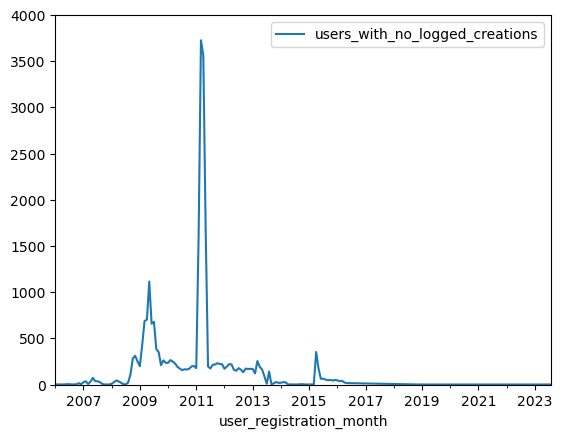

In [40]:
nonmatches_by_month.plot(ylim=(0, 4000))

That's a still a substantial number of events, but it's all historical at this point and the data isn't crucial as the user creation logs are not the canonical source of data for user registration. So I'm not going to investigate futher.

## Combined table
I've completed the query and run it for 2024-06, placing the results in `nshahquinn.active_editors_monthly`. Now I need to compare them to results of the existing job in `wmf_product.active_editors`.

In [16]:
aem_cur = wmf.presto.run("""
SELECT
    project AS wiki_id,
    project_family,
    active_editors AS active_editor_count,
    new_active_editors AS new_active_editor_count,
    returning_active_editors AS returning_active_editor_count
FROM wmf_product.active_editors
WHERE
    month = DATE '2024-06-01'
    AND market = 'All'
ORDER BY
    project_family,
    wiki_id
""").set_index(["project_family", "wiki_id"])

In [17]:
aem_new = wmf.presto.run("""
SELECT
    wiki_id,
    project_family,
    active_editor_count,
    new_active_editor_count,
    returning_active_editor_count
FROM nshahquinn.active_editors_monthly
ORDER BY
    project_family,
    wiki_id
""", catalog="analytics_iceberg").set_index(["project_family", "wiki_id"])

In [27]:
aem_diff = aem_new - aem_cur

In [28]:
aem_diff[aem_diff.isna().any(axis="columns")]

active_editor_count  new_active_editor_count  \
project_family wiki_id                                                        
foundation     All                             NaN                      NaN   
               foundationwiki                  NaN                      NaN   
incubator      incubatorwiki                   NaN                      NaN   
sources        All                             NaN                      NaN   
               sourceswiki                     NaN                      NaN   
wikibooks      fiwikibooks                     0.0                      NaN   
wikinews       fawikinews                      0.0                      NaN   
wikipedia      mniwiki                         0.0                      NaN   
wikiquote      cawikiquote                     0.0                      NaN   
               huwikiquote                     0.0                      NaN   
wikiversity    arwikiversity                   NaN                      NaN   
               cswikiversity                   NaN                      NaN   
               dewikiversity                   NaN                      NaN   
               enwikiversity                   NaN                      NaN   
               eswikiversity                   NaN                      NaN   
               frwikiversity                   NaN                      NaN   
               hiwikiversity                   NaN                      NaN   
               itwikiversity                   NaN                      NaN   
               jawikiversity                   NaN                      NaN   
               kowikiversity                   NaN                      NaN   
               ptwikiversity                   NaN                      NaN   
               ruwikiversity                   NaN                      NaN   
               slwikiversity                   NaN                      NaN   
               zhwikiversity                   NaN                      NaN   
wikivoyage     svwikivoyage                    0.0                      NaN   

                               returning_active_editor_count  
project_family wiki_id                                        
foundation     All                                       NaN  
               foundationwiki                            NaN  
incubator      incubatorwiki                             NaN  
sources        All                                       NaN  
               sourceswiki                               NaN  
wikibooks      fiwikibooks                               NaN  
wikinews       fawikinews                                NaN  
wikipedia      mniwiki                                   NaN  
wikiquote      cawikiquote                               NaN  
               huwikiquote                               NaN  
wikiversity    arwikiversity                             NaN  
               cswikiversity                             NaN  
               dewikiversity                             NaN  
               enwikiversity                             NaN  
               eswikiversity                             NaN  
               frwikiversity                             NaN  
               hiwikiversity                             NaN  
               itwikiversity                             NaN  
               jawikiversity                             NaN  
               kowikiversity                             NaN  
               ptwikiversity                             NaN  
               ruwikiversity                             NaN  
               slwikiversity                             NaN  
               zhwikiversity                             NaN  
wikivoyage     svwikivoyage                              NaN

The comparison is null in some cases because of the reasons we already discovered: (1) the current table leaves out a few database group and (2) the current version of `editor_month` has some missing user registration dates. We'll exclude those cases.

project_family  wiki_id             
All             All                     False
commons         All                     False
                commonswiki             False
foundation      All                      True
                foundationwiki           True
                                        ...  
wiktionary      vecwiktionary           False
                viwiktionary            False
                wawiktionary            False
                zh_min_nanwiktionary    False
                zhwiktionary            False
Length: 620, dtype: bool

In [31]:
aem_diff = aem_diff[~aem_diff.isna().any(axis="columns")]

In [35]:
aem_diff.sort_values("active_editor_count", ascending=False, key=abs).head(15)

active_editor_count  new_active_editor_count  \
project_family wiki_id                                                      
All            All                           3.0                   -142.0   
wikipedia      All                           3.0                    -64.0   
               scowiki                       1.0                      0.0   
               brwiki                        1.0                      0.0   
wikidata       All                           1.0                   -230.0   
               wikidatawiki                  1.0                   -230.0   
wikipedia      hywiki                        1.0                     -1.0   
               trwiki                        1.0                     -3.0   
               bgwiki                        1.0                     -2.0   
               guwiki                        1.0                     -1.0   
               cebwiki                       1.0                      0.0   
wikiquote      plwikiquote                   0.0                      0.0   
wikisource     All                           0.0                    -13.0   
               cswikisource                  0.0                      0.0   
               cawikisource                  0.0                      0.0   

                             returning_active_editor_count  
project_family wiki_id                                      
All            All                                   145.0  
wikipedia      All                                    67.0  
               scowiki                                 1.0  
               brwiki                                  1.0  
wikidata       All                                   231.0  
               wikidatawiki                          231.0  
wikipedia      hywiki                                  2.0  
               trwiki                                  4.0  
               bgwiki                                  3.0  
               guwiki                                  2.0  
               cebwiki                                 1.0  
wikiquote      plwikiquote                             0.0  
wikisource     All                                    13.0  
               cswikisource                            0.0  
               cawikisource                            0.0

The difference in overall active editors is miniscule, and is almost certainly because of an intentional tweak to have we calculate bot status in the new version of `editor_month`.

In [36]:
aem_diff.sort_values("returning_active_editor_count", ascending=False, key=abs).head(15)

active_editor_count  new_active_editor_count  \
project_family wiki_id                                                      
commons        commonswiki                   0.0                   -453.0   
               All                           0.0                   -453.0   
wikidata       wikidatawiki                  1.0                   -230.0   
               All                           1.0                   -230.0   
All            All                           3.0                   -142.0   
wikipedia      All                           3.0                    -64.0   
wiktionary     All                           0.0                    -35.0   
wikipedia      enwiki                        0.0                    -34.0   
               frwiki                        0.0                    -18.0   
               simplewiki                    0.0                    -17.0   
               eswiki                        0.0                    -16.0   
wikibooks      All                           0.0                    -15.0   
wikipedia      dewiki                        0.0                    -13.0   
               zhwiki                        0.0                     13.0   
wikisource     All                           0.0                    -13.0   

                             returning_active_editor_count  
project_family wiki_id                                      
commons        commonswiki                           453.0  
               All                                   453.0  
wikidata       wikidatawiki                          231.0  
               All                                   231.0  
All            All                                   145.0  
wikipedia      All                                    67.0  
wiktionary     All                                    35.0  
wikipedia      enwiki                                 34.0  
               frwiki                                 18.0  
               simplewiki                             17.0  
               eswiki                                 16.0  
wikibooks      All                                    15.0  
wikipedia      dewiki                                 13.0  
               zhwiki                                -13.0  
wikisource     All                                    13.0

The shifts between the returning and new categories are in line with what I saw previously due to the improved registration date calculation in the new version of `editor_month`.